# Evaluate Model Outputs

<div class="alert alert-block alert-danger">
<b> Project Name Setting: </b> Please set the Project Name for your project </div>

In [13]:
# PROJECT NAME HERE
PROJECT_NAME = "Blandy"
    
# PROJECT RESOLUTION HERE (m)
RESOLUTION = 30

In [14]:
import os, shutil

os.chdir("/scratch/tmb4ee/MODEL_62")

CURRENT_PATH = os.getcwd()
print(CURRENT_PATH)
PROJECT_DIR = os.path.join(CURRENT_PATH, PROJECT_NAME)
# Define raw GIS and observation data directory downloaded from HydroShare
RAWGIS_DIR = os.path.join(PROJECT_DIR, "gis_data")
RAWOBS_DIR = os.path.join(PROJECT_DIR, "obs")
RAWSOIL_DIR = os.path.join(RAWGIS_DIR, "soil")
# Define model input directory
MODEL_DIR = os.path.join(PROJECT_DIR, 'model')
# def directory
DEF_DIR = os.path.join(MODEL_DIR, 'defs')
# ini directory
INI_DIR = os.path.join(MODEL_DIR, 'ini_files')
#EPC Directory
EPC_DIR = os.path.join(MODEL_DIR, 'epc_files', 'epc_files')
# Model Output Path
OUTPUT_DIR = os.path.join(MODEL_DIR, 'output')
# CO2 file Path
CO2_DIR = os.path.join(MODEL_DIR, 'co2')
# Ndep file Path
NDEP_DIR = os.path.join(MODEL_DIR, 'ndep')
# Endpoint file Path
ENDPOINT_DIR = os.path.join(MODEL_DIR, 'endpoint_files')
# Spinup file Path
SPINUP_DIR = os.path.join(MODEL_DIR, 'spinup')
# Normal file Path
NORMAL_DIR = os.path.join(MODEL_DIR, 'normal')

# Define Output ASCII Raster Directory
MODEL_RAST_DIR = os.path.join(MODEL_DIR, 'raster_inputs')
# Define source code directory to use preprocessing from GitHub
IMAGE = os.path.join(PROJECT_DIR, 'image_map')

/scratch/tmb4ee/MODEL_62


In [15]:
import xarray as xr
import scipy
import pandas as pd
import re
from datetime import datetime, timedelta, date
import numpy as np
import matplotlib.pyplot as plt
from csv import reader
import math
import pyproj
from pyproj import CRS, Transformer, Proj, transform
import dask.array as da
import multiprocessing
from time import time
import glob

In [16]:
# Read main.def
main_def = os.path.join(DEF_DIR, "main.def")
with open(main_def, 'r') as file:
    # read a list of lines into data
    main_def_lines = file.readlines()

main_d = {}
for i in main_def_lines:
    line = list(filter(None, re.split(r'\s', i)))
    if len(line) == 2:
        main_d[line[0]] = line[1]
print(main_d)

{'TYPE': 'FILENAME', 's_ini': 's.ini', 'n_ini': 'n.ini', 'co2': 'CO2.txt', 'ndep': 'Ndep.txt', 'SPINUP': 'DATE', 's_start_date': '1980-01-01', 's_end_date': '2021-12-31', 'NORMAL': 'DATE', 'n_start_date': '1980-01-01', 'n_end_date': '2021-12-31'}


In [17]:
# Read daymet cell code/value def and set up to be used in file concatenation
cell_values_csv = os.path.join(DEF_DIR, "cell_values.csv")
cell_values = np.genfromtxt(cell_values_csv, delimiter=',').astype(int).T.tolist()

cell_value_dict = {}
num = 0
for i in cell_values:
    cell_value_dict[num] = i
    print(f"{num}: {i}")
    num += 1

0: [3, 6]
1: [4, 7]


### Combine Original Output Files Across Same Latitudes

In [5]:
def latitude_combination(row_cell_list):
#     print(row_cell_list)
    input_files = " ".join(map(str, [os.path.join(OUTPUT_DIR, str(x) + ".nc") for x in row_cell_list[1]]))
    
    file_1 = os.path.join(OUTPUT_DIR, f"lon_{str(row_cell_list[0])}_n.nc")
    ! ncrcat -O --no_tmp_fl {input_files} {file_1}
    
#     for file in [os.path.join(OUTPUT_DIR, str(x) + ".nc") for x in row_cell_list[1]]:
#         os.remove(file)
    

pool = multiprocessing.Pool(processes=len(cell_values))
normal_map = pool.map(latitude_combination, cell_value_dict.items())

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-52b157c949c9>", line 13, in <module>
    normal_map = pool.map(latitude_combination, cell_value_dict.items())
  File "/env/lib/python3.7/multiprocessing/pool.py", line 268, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/env/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/env/lib/python3.7/multiprocessing/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/env/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/env/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/env/lib/python3.7/site-packages

TypeError: object of type 'NoneType' has no len()

### Display Meteorological Data

In [18]:
met_data = xr.open_dataset(os.path.join(MODEL_DIR, 'met_data', 'aoi_met.nc'))
daymet_proj = Proj("+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs")

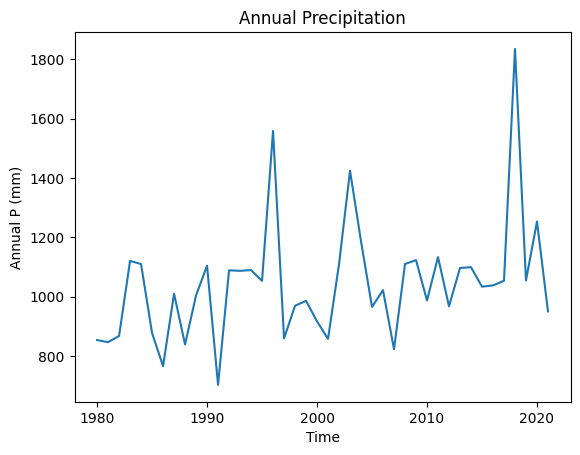

In [19]:
precip = met_data["prcp"].resample(time="Y").sum().mean(dim='y', skipna=True).mean(dim='x', skipna=True)
precip['time'] = precip['time.year']
precip.to_series().plot(title='Annual Precipitation', xlabel='Time', ylabel='Annual P (mm)')

plt.show()

### Open Single Output File Using Xarray open_mfdataset With Combined Lat Files

In [20]:
# opened_final = xr.open_mfdataset(os.path.join(OUTPUT_DIR, "*_n.nc"))
opened_final = xr.open_mfdataset(os.path.join(OUTPUT_DIR, "*.nc"))
opened_final

<xarray.Dataset>
Dimensions:              (lat: 36, long: 36, time: 15330)
Coordinates:
  * time                 (time) datetime64[ns] 1980-01-01 ... 2021-12-31
  * long                 (long) int64 1792965 1792995 ... 1793985 1794015
  * lat                  (lat) int64 -126825 -126855 -126885 ... -127845 -127875
Data variables: (12/32)
    year                 (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    month                (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    day                  (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    yday                 (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    evapotransp          (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    soilw_evap           (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    ...                   ...
    WbalanceERR          (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    inW                  (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    outW                 (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    storeW               (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    groundwater_snk      (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>
    iterstep_Richards    (lat, long, time) float64 dask.array<chunksize=(24, 10, 15330), meta=np.ndarray>

### Display Model Results

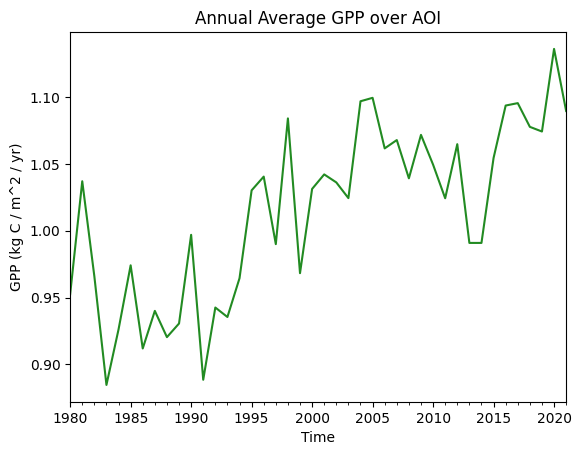

In [21]:
gpp_agg = opened_final["daily_gpp"]
gpp_agg = gpp_agg.resample(time="Y").sum().mean(dim='lat', skipna=True).mean(dim='long', skipna=True)
gpp_agg.to_series().plot(title='Annual Average GPP over AOI', xlabel='Time', ylabel='GPP (kg C / m^2 / yr)', color='forestgreen')

plt.show()

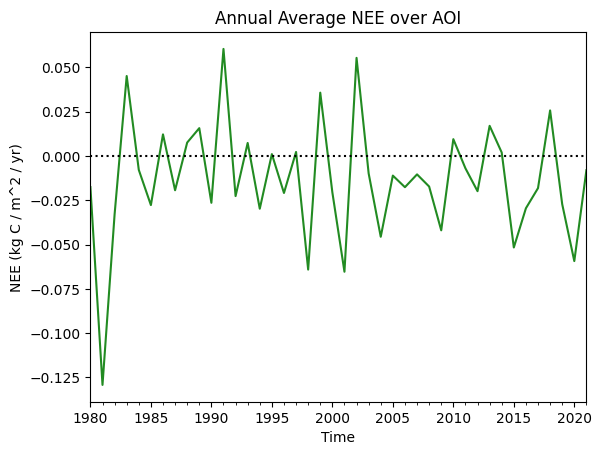

In [22]:
nee_agg = opened_final["daily_nee"]
nee_agg = nee_agg.resample(time="Y").sum().mean(dim='lat', skipna=True).mean(dim='long', skipna=True)
nee_agg.to_series().plot(title='Annual Average NEE over AOI', xlabel='Time', ylabel='NEE (kg C / m^2 / yr)', color='forestgreen')
plt.axhline(y=0.0, color='black', linestyle='dotted')

plt.show()

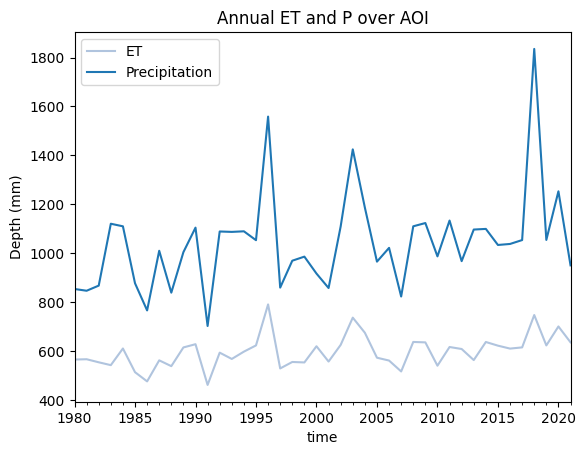

In [23]:
et_agg = opened_final["evapotransp"]
et_agg = et_agg.resample(time="Y").sum().mean(dim='lat', skipna=True).mean(dim='long', skipna=True).rename("ET")
# et_agg['time'] = et_agg['time'].astype(int)
et_agg.to_series().plot(title='Annual ET and P over AOI', xlabel='Time', ylabel='ET (mm)', legend=True, color='lightsteelblue')

precip = met_data["prcp"].resample(time="Y").sum().mean(dim='y', skipna=True).mean(dim='x', skipna=True).rename("Precipitation")
ax = precip.to_series().plot(secondary_y=False, legend=True)

ax.set_ylabel('Depth (mm)')

plt.show()

<Figure size 750x350 with 0 Axes>

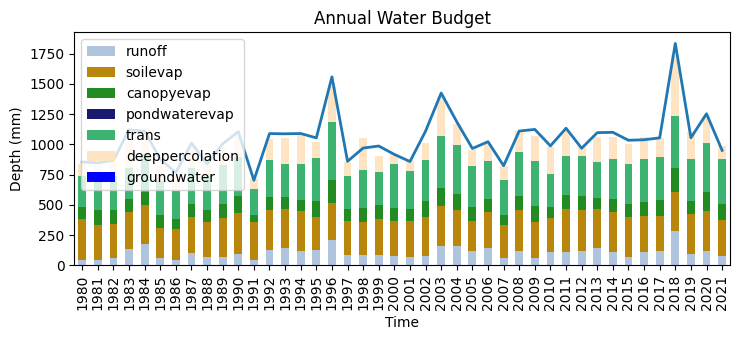

In [24]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

runoff_snk = opened_final["runoff_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
runoff_snk['Lag'] = runoff_snk["runoff_snk"].shift(1).fillna(0)
runoff_snk['runoff'] = runoff_snk["runoff_snk"] - runoff_snk['Lag']

soilevap_snk = opened_final["soilevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
soilevap_snk['Lag'] = soilevap_snk["soilevap_snk"].shift(1).fillna(0)
soilevap_snk['soilevap'] = soilevap_snk["soilevap_snk"] - soilevap_snk['Lag']

canopyevap_snk = opened_final["canopyevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
canopyevap_snk['Lag'] = canopyevap_snk["canopyevap_snk"].shift(1).fillna(0)
canopyevap_snk['canopyevap'] = canopyevap_snk["canopyevap_snk"] - canopyevap_snk['Lag']

pondwevap_snk = opened_final["pondwevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
pondwevap_snk['Lag'] = pondwevap_snk["pondwevap_snk"].shift(1).fillna(0)
pondwevap_snk['pondwaterevap'] = pondwevap_snk["pondwevap_snk"] - pondwevap_snk['Lag']

trans_snk = opened_final["trans_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
trans_snk['Lag'] = trans_snk["trans_snk"].shift(1).fillna(0)
trans_snk['trans'] = trans_snk["trans_snk"] - trans_snk['Lag']

groundwater_src = opened_final["groundwater_src"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
groundwater_src['Lag'] = groundwater_src["groundwater_src"].shift(1).fillna(0)
groundwater_src['groundwater'] = groundwater_src["groundwater_src"] - groundwater_src['Lag']

deeppercolation_snk = opened_final["deeppercolation_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
deeppercolation_snk['Lag'] = deeppercolation_snk["deeppercolation_snk"].shift(1).fillna(0)
deeppercolation_snk['deeppercolation'] = deeppercolation_snk["deeppercolation_snk"] - deeppercolation_snk['Lag']

water_budget = pd.concat([runoff_snk['runoff'], soilevap_snk['soilevap'], canopyevap_snk['canopyevap'], pondwevap_snk['pondwaterevap'], trans_snk['trans'], deeppercolation_snk['deeppercolation'], groundwater_src['groundwater']], axis=1)
water_budget = water_budget.resample("Y").sum()

precip = met_data["prcp"].resample(time="Y").sum().mean(dim='y', skipna=True).mean(dim='x', skipna=True)
precip_frame = precip.to_series().to_frame()

water_budget = pd.concat([water_budget, precip_frame], axis=1)
water_budget.index = water_budget.index.year

fig = plt.figure()
ax = water_budget[["runoff", "soilevap", "canopyevap", "pondwaterevap", "trans", "deeppercolation", "groundwater"]].plot(kind='bar', stacked=True, title='Annual Water Budget', color=['lightsteelblue','darkgoldenrod','forestgreen','midnightblue','mediumseagreen','bisque', 'Blue'])
ax.plot(water_budget[['prcp']].values, linestyle='-', linewidth=2.0)
ax.set_xlabel('Time')
ax.set_ylabel('Depth (mm)')
# plt.legend(["Precipitation", "ET", "Runoff", "Deep Leaching/Percolation"]) 
# combined_hydro[['prcp']].plot(kind='line', color='black', ms=10)

plt.show()

# cumulative_frame['daily'].resample("Y").sum().plot()
# plt.show()

<Figure size 750x350 with 0 Axes>

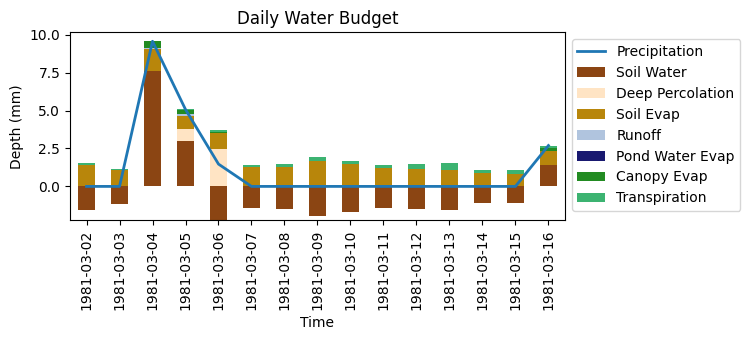

In [25]:
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

runoff_snk = opened_final["runoff_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
runoff_snk['Lag'] = runoff_snk["runoff_snk"].shift(1).fillna(0)
runoff_snk['runoff'] = runoff_snk["runoff_snk"] - runoff_snk['Lag']

soilevap_snk = opened_final["soilevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
soilevap_snk['Lag'] = soilevap_snk["soilevap_snk"].shift(1).fillna(0)
soilevap_snk['soilevap'] = soilevap_snk["soilevap_snk"] - soilevap_snk['Lag']

canopyevap_snk = opened_final["canopyevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
canopyevap_snk['Lag'] = canopyevap_snk["canopyevap_snk"].shift(1).fillna(0)
canopyevap_snk['canopyevap'] = canopyevap_snk["canopyevap_snk"] - canopyevap_snk['Lag']

pondwevap_snk = opened_final["pondwevap_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
pondwevap_snk['Lag'] = pondwevap_snk["pondwevap_snk"].shift(1).fillna(0)
pondwevap_snk['pondwaterevap'] = pondwevap_snk["pondwevap_snk"] - pondwevap_snk['Lag']

trans_snk = opened_final["trans_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
trans_snk['Lag'] = trans_snk["trans_snk"].shift(1).fillna(0)
trans_snk['trans'] = trans_snk["trans_snk"] - trans_snk['Lag']

deeppercolation_snk = opened_final["deeppercolation_snk"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
deeppercolation_snk['Lag'] = deeppercolation_snk["deeppercolation_snk"].shift(1).fillna(0)
deeppercolation_snk['deeppercolation'] = deeppercolation_snk["deeppercolation_snk"] - deeppercolation_snk['Lag']

soilw_SUM = opened_final["soilw_SUM"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
soilw_SUM['Lag'] = soilw_SUM["soilw_SUM"].shift(1).fillna(0)
soilw_SUM['soilw'] = soilw_SUM["soilw_SUM"] - soilw_SUM['Lag']

prcp_src = opened_final["prcp_src"].mean(dim='lat', skipna=True).mean(dim='long', skipna=True).to_series().to_frame()
prcp_src['Lag'] = prcp_src["prcp_src"].shift(1).fillna(0)
prcp_src['prcp'] = prcp_src["prcp_src"] - prcp_src['Lag']

water_budget = pd.concat([runoff_snk['runoff'], soilevap_snk['soilevap'], canopyevap_snk['canopyevap'], pondwevap_snk['pondwaterevap'], trans_snk['trans'], deeppercolation_snk['deeppercolation'], groundwater_src['groundwater'], soilw_SUM['soilw'], prcp_src['prcp']], axis=1)
water_budget.index = water_budget.index.date
water_budget = water_budget.iloc[425:440]

fig = plt.figure()
ax = water_budget[["soilw", "deeppercolation", "soilevap", "runoff", "pondwaterevap", "canopyevap", "trans"]].plot(kind='bar', stacked=True, title='Daily Water Budget', color=['saddlebrown', 'bisque', 'darkgoldenrod','lightsteelblue','midnightblue','forestgreen','mediumseagreen'])
ax.plot(water_budget[['prcp']].values, linestyle='-', linewidth=2.0)
ax.set_xlabel('Time')
ax.set_ylabel('Depth (mm)')
plt.legend(["Precipitation", "Soil Water", "Deep Percolation", "Soil Evap", "Runoff", "Pond Water Evap", "Canopy Evap", "Transpiration"], bbox_to_anchor=(1, 1)) 
# ax.legend(bbox_to_anchor=(1, 1))

plt.show()

### Map Sample of Outputs

In [26]:
# %matplotlib inline

/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


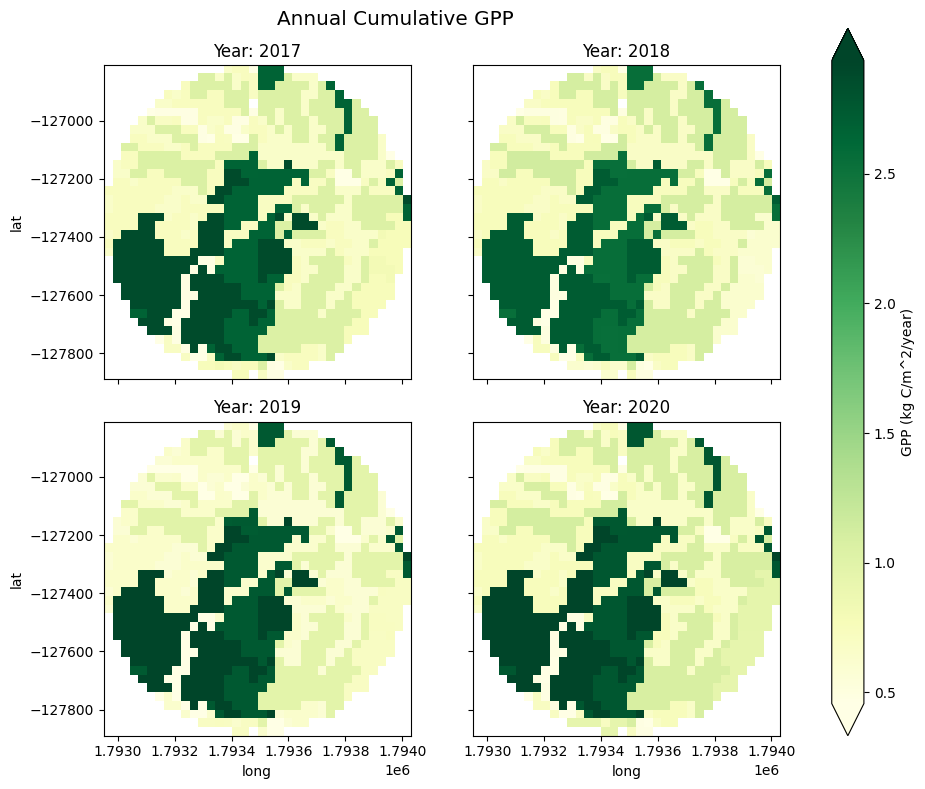

In [27]:
annual_gpp = opened_final["daily_gpp"].resample(time="Y", skipna=False).sum(skipna=False).isel(time=[37,38,39,40]).rename("GPP (kg C/m^2/year)")
# daily_gpp = opened_final["daily_gpp"].isel(time=[135,136,137,138])
gpp = annual_gpp.plot.imshow(x="long", y="lat", col="time", col_wrap=2, robust=True, figsize=(8, 8), cmap='YlGn', cbar_kwargs={'location': 'right', 'anchor': (2.5, 0.5), 'panchor': (1.0, 0.5)})
gpp.fig.suptitle('Annual Cumulative GPP', fontsize='x-large')

start_year = 2017
for i, ax in enumerate(gpp.axes.flatten()):
    ax.set_title('Year: %d' % (start_year + i))

plt.show()

/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


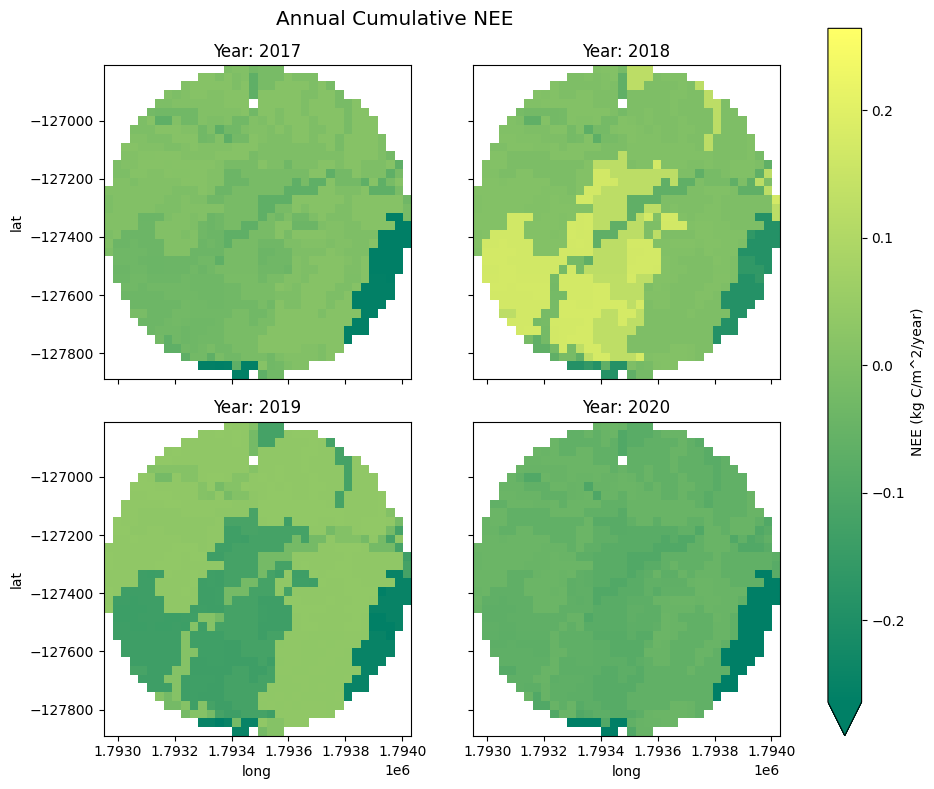

In [28]:
annual_nee = opened_final["daily_nee"].resample(time="Y", skipna=False).sum(skipna=False).isel(time=[37,38,39,40]).rename("NEE (kg C/m^2/year)")
nee = annual_nee.plot.imshow(x="long", y="lat", col="time", col_wrap=2, robust=True, figsize=(8, 8), cmap='summer', cbar_kwargs={'location': 'right', 'anchor': (2.5, 0.5), 'panchor': (1.0, 0.5)})
nee.fig.suptitle('Annual Cumulative NEE', fontsize='x-large')

start_year = 2017
for i, ax in enumerate(nee.axes.flatten()):
    ax.set_title('Year: %d' % (start_year + i))

plt.show()

/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


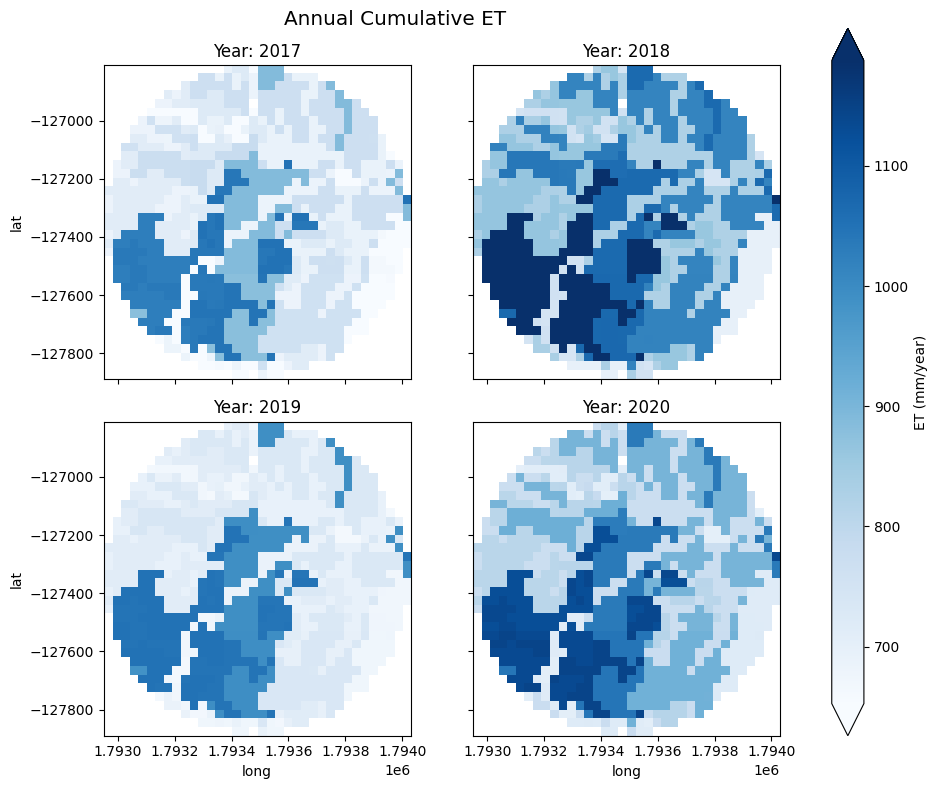

In [29]:
evapotransp = opened_final["evapotransp"].resample(time="Y", skipna=False).sum(skipna=False).isel(time=[37,38,39,40]).rename("ET (mm/year)")
et = evapotransp.plot.imshow(x="long", y="lat", col="time", col_wrap=2, robust=True, figsize=(8, 8), cmap='Blues', cbar_kwargs={'location': 'right', 'anchor': (2.5, 0.5), 'panchor': (1.0, 0.5)})
et.fig.suptitle('Annual Cumulative ET', fontsize='x-large')

start_year = 2017
for i, ax in enumerate(et.axes.flatten()):
    ax.set_title('Year: %d' % (start_year + i))

plt.show()

/env/lib/python3.7/site-packages/IPython/core/pylabtools.py:134: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


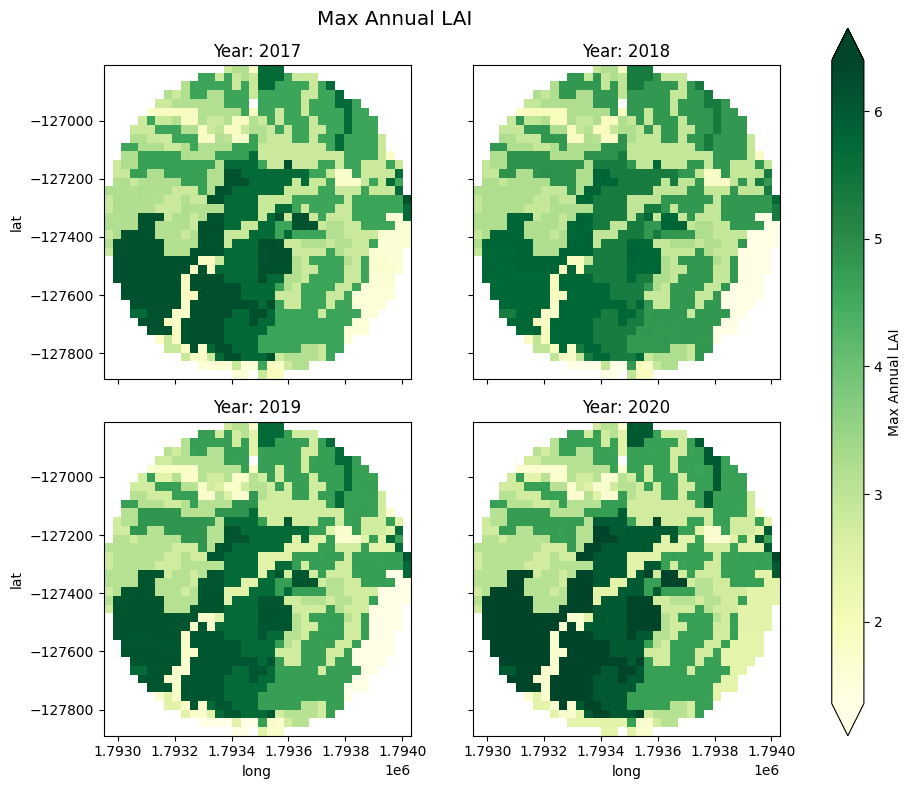

In [30]:
lai = opened_final["proj_lai"].resample(time="Y", skipna=False).max(skipna=False).isel(time=[37,38,39,40]).rename("Max Annual LAI")
lai = lai.plot.imshow(x="long", y="lat", col="time", col_wrap=2, robust=True, figsize=(8, 8), cmap='YlGn', cbar_kwargs={'location': 'right', 'anchor': (2.5, 0.5), 'panchor': (1.0, 0.5)})
lai.fig.suptitle('Max Annual LAI', fontsize='x-large')

start_year = 2017
for i, ax in enumerate(lai.axes.flatten()):
    ax.set_title('Year: %d' % (start_year + i))

plt.show()

## Below: Data Analysis Only Applicable to 1 km2 Run at Blandy Tower Site

In [31]:
import matplotlib.pyplot as plt

In [32]:
tower_data = pd.read_csv(os.path.join(CURRENT_PATH, "daily_ML_ameriflux.csv"))
tower_data.set_index('TIMESTAMP_START', inplace=True)
tower_data.index = pd.to_datetime(tower_data.index)
tower_data["NEE_PI"] = tower_data["NEE_PI"]*(0.001037664)
tower_data["SWC_Depth1"] = tower_data[["SWC_1_1_1", "SWC_2_1_1", "SWC_3_1_1", "SWC_4_1_1", "SWC_5_1_1"]].mean(axis=1)
tower_data["SWC_Depth2"] = tower_data[["SWC_1_2_1", "SWC_2_2_1", "SWC_3_2_1", "SWC_4_2_1", "SWC_5_2_1"]].mean(axis=1)
tower_data["SWC_Depth3"] = tower_data[["SWC_1_3_1", "SWC_2_3_1", "SWC_3_3_1", "SWC_4_3_1", "SWC_5_3_1"]].mean(axis=1)
tower_data["SWC_Depth4"] = tower_data[["SWC_1_4_1", "SWC_2_4_1", "SWC_3_4_1", "SWC_4_4_1", "SWC_5_4_1"]].mean(axis=1)
tower_data["SWC_Depth5"] = tower_data[["SWC_1_5_1", "SWC_2_5_1", "SWC_3_5_1", "SWC_4_5_1", "SWC_5_5_1"]].mean(axis=1)
tower_data["SWC_Depth6"] = tower_data[["SWC_1_6_1", "SWC_2_6_1", "SWC_3_6_1", "SWC_4_6_1", "SWC_5_6_1"]].mean(axis=1)
tower_data["SWC_Depth7"] = tower_data[["SWC_1_7_1", "SWC_2_7_1", "SWC_3_7_1"]].mean(axis=1)
tower_data["SWC_Depth8"] = tower_data[["SWC_1_8_1", "SWC_2_8_1", "SWC_3_8_1"]].mean(axis=1)

tower_data

,NEE_PI,NETRAD,LE,VPD_PI,SWC_1_1_1,SWC_1_2_1,SWC_1_3_1,SWC_1_4_1,SWC_1_5_1,SWC_1_6_1,...,P,ET,SWC_Depth1,SWC_Depth2,SWC_Depth3,SWC_Depth4,SWC_Depth5,SWC_Depth6,SWC_Depth7,SWC_Depth8
TIMESTAMP_START,,,,,,,,,,,,,,,,,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.001072,21.203542,0.207482,1.540846,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.007943,8.246778,15.709792,12.666820,12.950333,10.644167,17.350792,30.280870,NaN
2021-12-28,0.001353,25.276667,14.850915,1.673752,NaN,NaN,NaN,NaN,NaN,NaN,...,3.447,0.568506,8.698200,15.748012,11.373460,6.165000,10.532500,19.208706,30.316571,NaN
2021-12-29,0.001615,21.532083,-9.341861,0.861950,NaN,NaN,NaN,NaN,NaN,NaN,...,8.861,-0.357615,9.481842,15.921117,11.507679,6.566471,10.544130,22.141004,30.305854,NaN


Pearson r:  0.39
NSE: -0.45
KGE:  -0.69 



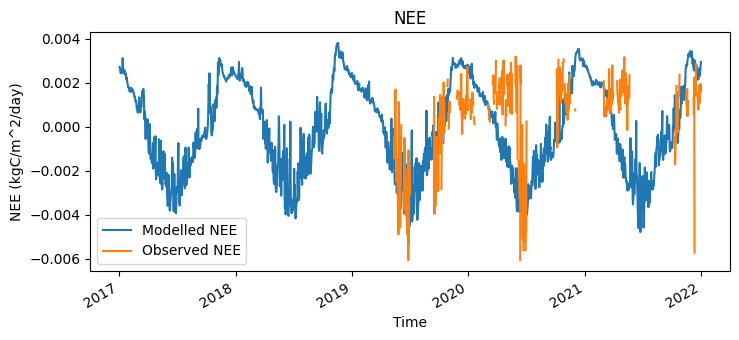

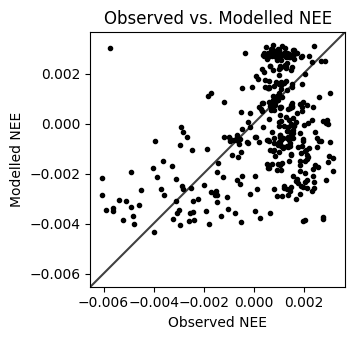

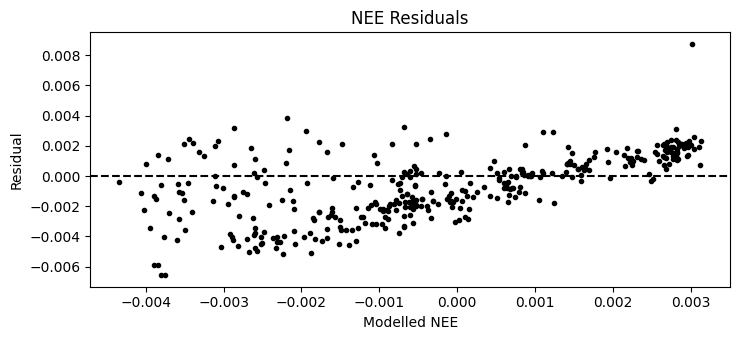

In [33]:
obs_nee = tower_data["NEE_PI"]

# FILTER OUTLIER DATA FROM OBSERVED
q_low = obs_nee.quantile(0.025)
q_hi  = obs_nee.quantile(0.975)
obs_filtered = obs_nee[(obs_nee < q_hi) & (obs_nee > q_low)]

# COMBINE OBSERVED AND MODELLED VALUES AND FILTER BY TIME RANGE OF INTEREST, PLOT COMPARITIVE TIME SERIES
blandy_nee_mean = opened_final["daily_nee"].mean(dim='lat', skipna=True)
blandy_nee_mean = blandy_nee_mean.mean(dim='long', skipna=True)
blandy_nee_mean = blandy_nee_mean.sel(time=slice('2017-01-01', '2021-12-31'))
blandy_nee_mean_series = blandy_nee_mean.to_series()
blandy_nee_mean_series.index

nee_combined = pd.DataFrame({'Modelled NEE': blandy_nee_mean_series,'Observed NEE': obs_filtered})
mask = (nee_combined.index > '2017-01-01') & (nee_combined.index <= '2021-12-31')
nee_combined = nee_combined.loc[mask]
nee_combined.plot(title='NEE', xlabel='Time', ylabel='NEE (kgC/m^2/day)')

# CALCULATE PEARSONS R CORRELATION COEFFICIENT
pearson_r_grid = nee_combined.corr(method='pearson')
pearson_r = pearson_r_grid.at['Observed NEE', 'Modelled NEE']
print('Pearson r: ', round(pearson_r, 2))

# MANUAL METHOD FOR CALCULATING PEARSON COEFFICIENT R
# n = nee_combined["Observed NEE"].count()
# sum_xy = (nee_combined["Observed NEE"]*nee_combined["Modelled NEE"]).sum()
# nee_combined["Modelled_removed_na"] = nee_combined["Modelled NEE"] + nee_combined["Observed NEE"] - nee_combined["Observed NEE"]

# r = ((n)*sum_xy - (nee_combined["Modelled_removed_na"].sum()*nee_combined["Observed NEE"].sum()))/((((n*(nee_combined["Modelled_removed_na"]**2).sum())-(nee_combined["Modelled_removed_na"].sum())**2)*((n*(nee_combined["Observed NEE"]**2).sum())-(nee_combined["Observed NEE"].sum())**2))**(1/2))
# print(round(r,2))

#CALCULATE NSE
nee_combined['nse_top'] = (nee_combined["Observed NEE"] - nee_combined["Modelled NEE"])**2
nee_combined['nse_bottom'] = (nee_combined["Observed NEE"] - (nee_combined["Observed NEE"]).mean())**2
NSE = 1 - (nee_combined['nse_top'].sum() / nee_combined['nse_bottom'].sum())
print(f'NSE: {round(NSE, 2)}')

# CALCULATE KGE: https://agrimetsoft.com/calculators/Kling-Gupta%20efficiency
nee_combined["Modelled_removed_na"] = nee_combined["Modelled NEE"] + nee_combined["Observed NEE"] - nee_combined["Observed NEE"]
KGE = 1 - ((pearson_r-1)**2+((nee_combined["Modelled_removed_na"].std()/nee_combined["Observed NEE"].std())-1)**2+((nee_combined["Modelled_removed_na"].mean()/nee_combined["Observed NEE"].mean())-1)**2)**(1/2)
print('KGE: ', round(KGE, 2),  '\n')

plt.show()
print('\n')

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#OBSERVED VS MODELLED SCATTERPLOT
fig, ax = plt.subplots()

plt.plot(nee_combined["Observed NEE"], nee_combined["Modelled NEE"], '.k')
plt.title('Observed vs. Modelled NEE')
plt.xlabel('Observed NEE')
plt.ylabel('Modelled NEE')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#PLOT RESIDUALS
nee_combined['residual'] = nee_combined["Modelled NEE"] - nee_combined["Observed NEE"]

plt.plot(nee_combined["Modelled NEE"], nee_combined['residual'], '.k')
plt.title('NEE Residuals')
plt.xlabel('Modelled NEE')
plt.ylabel('Residual')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

Pearson r:  0.55
NSE: -0.14
KGE:  0.34 



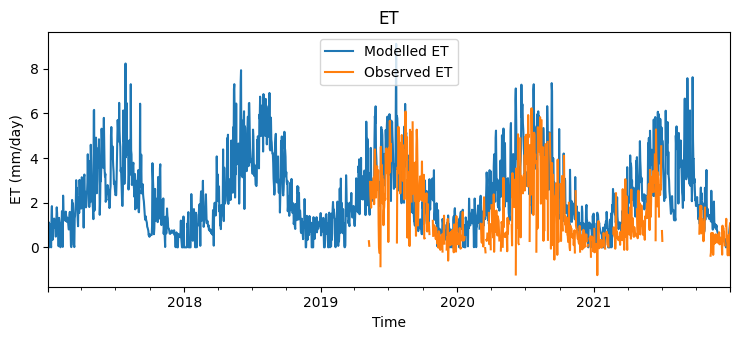

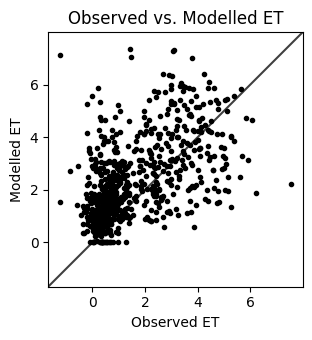

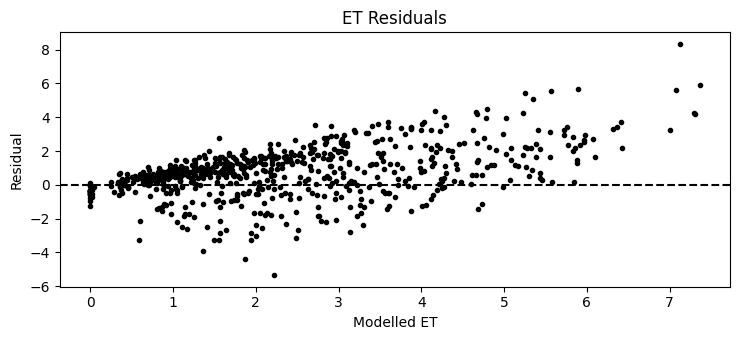

In [34]:
obs_et = tower_data["ET"]

# COMBINE OBSERVED AND MODELLED VALUES AND FILTER BY TIME RANGE OF INTEREST, PLOT COMPARITIVE TIME SERIES
blandy_et_mean = opened_final["evapotransp"].mean(dim='lat', skipna=True)
blandy_et_mean = blandy_et_mean.mean(dim='long', skipna=True)
blandy_et_mean = blandy_et_mean.sel(time=slice('2017-01-01', '2021-12-31'))
blandy_et_mean_series = blandy_et_mean.to_series()
blandy_et_mean_series.index

et_combined = pd.DataFrame({'Modelled ET': blandy_et_mean_series,'Observed ET': obs_et})
mask = (et_combined.index > '2017-01-01') & (et_combined.index <= '2021-12-31')
et_combined = et_combined.loc[mask]
et_combined.plot(title='ET', xlabel='Time', ylabel='ET (mm/day)')

# CALCULATE PEARSONS R CORRELATION COEFFICIENT
pearson_r_grid = et_combined.corr(method='pearson')
pearson_r = pearson_r_grid.at['Observed ET', 'Modelled ET']
print('Pearson r: ', round(pearson_r, 2))

#CALCULATE NSE
et_combined['et_top'] = (et_combined["Observed ET"] - et_combined["Modelled ET"])**2
et_combined['et_bottom'] = (et_combined["Observed ET"] - et_combined["Observed ET"].mean())**2
NSE = 1 - (et_combined['et_top'].sum() / et_combined['et_bottom'].sum())
print(f'NSE: {round(NSE, 2)}')

# CALCULATE KGE: https://agrimetsoft.com/calculators/Kling-Gupta%20efficiency
et_combined["Modelled_removed_na"] = et_combined["Modelled ET"] + et_combined["Observed ET"] - et_combined["Observed ET"]
KGE = 1 - ((pearson_r-1)**2+((et_combined["Modelled_removed_na"].std()/et_combined["Observed ET"].std())-1)**2+((et_combined["Modelled_removed_na"].mean()/et_combined["Observed ET"].mean())-1)**2)**(1/2)
print('KGE: ', round(KGE, 2),  '\n')

plt.show()
print('\n')

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
# OBSERVED VS MODELLED SCATTERPLOT
fig, ax = plt.subplots()

plt.plot(et_combined["Observed ET"], et_combined["Modelled ET"], '.k')
plt.title('Observed vs. Modelled ET')
plt.xlabel('Observed ET')
plt.ylabel('Modelled ET')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.show()

# ------------------------------------------------------------------------------------------------------------------------------------------------------------------
#PLOT RESIDUALS
et_combined['residual'] = et_combined["Modelled ET"] - et_combined["Observed ET"]

plt.plot(et_combined["Modelled ET"], et_combined['residual'], '.k')
plt.title('ET Residuals')
plt.xlabel('Modelled ET')
plt.ylabel('Residual')
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

In [19]:
# # COORDINATE SYSTEM HERE
# COORDINATE_SYSTEM = CRS("EPSG:26917")
# crs_wgs = CRS("WGS84")
# transformer = Transformer.from_crs(crs_wgs, COORDINATE_SYSTEM)

# soil_plot_loc = [[39.06032, -78.07179], [39.06052, -78.07224],[39.06073, -78.07269], [39.06073, -78.07269], [39.06073, -78.07269]]
# soil_xy_list = []
# for plot in soil_plot_loc:
#     x,y = transformer.transform(plot[0], plot[1])
#     x,y = int(math.floor(x/RESOLUTION)*RESOLUTION+(RESOLUTION/2)), int(math.floor(y/RESOLUTION)*RESOLUTION+(RESOLUTION/2))
#     soil_xy_list.append([x,y])
    
# print(soil_xy_list)

# i = 0
# for coord in soil_xy_list:
#     temp = opened_final.sel(long=soil_xy_list[i][0], lat=soil_xy_list[i][1])
#     temp = temp.assign_coords(coords={'record':i, 'lat':lat, 'long':lon})
# #     display(temp)
#     if i == 0:
#         select = temp
#     else:
#         select = xr.concat([temp, select], dim='record')
#     i += 1
# select = select.mean(dim='record', skipna=True)
# display(select) 

In [20]:
# """
# OBSERVED DEPTHS ARE WRONG - ACCIDENTLY USED THE DEPTHS FROM COWEETA TEST. FIND BLANDY SOIL PROBE DEPTHS 1-8 
# """

# # 5 cm
# obs_swc = tower_data["SWC_Depth2"]
# obs_swc

# blandy_swc1_mean = (select["soilw2"]/30)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 5-10 cm': blandy_swc1_mean_series,'Observed SWC 5 cm': obs_swc})
# swc1_combined.plot(title='SWC 5 cm', xlabel='Time', ylabel='SWC (%)')


# # 15 cm
# obs_swc = tower_data["SWC_Depth2"]
# obs_swc

# blandy_swc1_mean = (select["soilw4"]/100)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 10-20 cm': blandy_swc1_mean_series,'Observed SWC 15 cm': obs_swc})
# swc1_combined.plot(title='SWC 15 cm', xlabel='Time', ylabel='SWC (%)')

# # 25 cm
# obs_swc = tower_data["SWC_Depth3"]
# obs_swc

# blandy_swc1_mean = (select["soilw5"]/300)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 20-50 cm': blandy_swc1_mean_series,'Observed SWC 25 cm': obs_swc})
# swc1_combined.plot(title='SWC 25 cm', xlabel='Time', ylabel='SWC (%)')

# # 25 cm
# obs_swc = tower_data["SWC_Depth4"]
# obs_swc

# blandy_swc1_mean = (select["soilw5"]/300)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 20-50 cm': blandy_swc1_mean_series,'Observed SWC 25 cm': obs_swc})
# swc1_combined.plot(title='SWC 25 cm', xlabel='Time', ylabel='SWC (%)')

# # 35 cm
# obs_swc = tower_data["SWC_Depth5"]
# obs_swc

# blandy_swc1_mean = (select["soilw5"]/300)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 20-50 cm': blandy_swc1_mean_series,'Observed SWC 35 cm': obs_swc})
# swc1_combined.plot(title='SWC 35 cm', xlabel='Time', ylabel='SWC (%)')

# # 65 cm
# obs_swc = tower_data["SWC_Depth6"]
# obs_swc

# blandy_swc1_mean = (select["soilw6"]/500)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 50-100 cm': blandy_swc1_mean_series,'Observed SWC 65 cm': obs_swc})
# swc1_combined.plot(title='SWC 65 cm', xlabel='Time', ylabel='SWC (%)')

# # 105 cm
# obs_swc = tower_data["SWC_Depth7"]
# obs_swc

# blandy_swc1_mean = (select["soilw7"]/500)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 100-150 cm': blandy_swc1_mean_series,'Observed SWC 105 cm': obs_swc})
# swc1_combined.plot(title='SWC 105 cm', xlabel='Time', ylabel='SWC (%)')

# # 145 cm
# obs_swc = tower_data["SWC_Depth8"]
# obs_swc

# blandy_swc1_mean = (select["soilw7"]/500)*100
# blandy_swc1_mean = blandy_swc1_mean.sel(time=slice('2017-01-01', '2020-12-31'))
# blandy_swc1_mean_series = blandy_swc1_mean.to_series()
# blandy_swc1_mean_series.index

# swc1_combined = pd.DataFrame({'Modelled SWC 100-150 cm': blandy_swc1_mean_series,'Observed SWC 145 cm': obs_swc})
# swc1_combined.plot(title='SWC 145 cm', xlabel='Time', ylabel='SWC (%)')